In [30]:
# csce 487 intro to ML
# assignment 3 - Naive Bays Classifier & Logistic Regression
# collaborators : Changsu Kim, Jesse Reyes Cortes


#################             NAIVE BAYES CLASSIFIER             #################

# part A: model code (design multinomial naive bayes)
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns

import nltk
nltk.download('wordnet')
nltk.download('punkt')


from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\devan\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\devan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [26]:
!pip install nltk

In [27]:
# part B: exploratory data analysis
# B.2 read in SMSSpamCollection.csv as DataFrame
df = pd.read_csv('SMSSpamCollection_copy', delimiter='\t');
df.columns = ['spam', 'text'] 
print(df)
#print(len(df.columns))
#dropping null value columns to avoid errorsk
#df.dropna(inplace = True)
#split value columns
#df['text'] = df['text'].str.split("t", n = 1, expand = True)
#print(df[0])
#print(df[1])
#print(df)
#df = df.reindex(columns=['text','label'])
#print(df.shape[1])
df['spam'] = np.where(df['spam'] == "spam", 1, 0) #broadcasting
df.head()
df.info()
print("Dimension of the data: ", df.shape)

      spam                                               text
0      ham                      Ok lar... Joking wif u oni...
1     spam  Free entry in 2 a wkly comp to win FA Cup fina...
2      ham  U dun say so early hor... U c already then say...
3      ham  Nah I don't think he goes to usf, he lives aro...
4     spam  FreeMsg Hey there darling it's been 3 week's n...
...    ...                                                ...
5566  spam  This is the 2nd time we have tried 2 contact u...
5567   ham               Will ü b going to esplanade fr home?
5568   ham  Pity, * was in mood for that. So...any other s...
5569   ham  The guy did some bitching but I acted like i'd...
5570   ham                         Rofl. Its true to its name

[5571 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5571 entries, 0 to 5570
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   spam    5571 non-null   int32 
 1   text    5571

In [28]:
# B.3 summerization of data in terms of mean, standard deviation, and quartiles
no_of_rows = df.shape[0]
no_of_columns = df.shape[1]

print("\nNo. of Rows: %d" % no_of_rows)
print("No. of Columns: %d" % no_of_columns)
df.groupby('spam').count()
df.groupby('spam').length.describe()


No. of Rows: 5571
No. of Columns: 2


AttributeError: 'DataFrameGroupBy' object has no attribute 'length'

In [ ]:
# B.4 generate plot to display class distribution
label_counts = df.spam.value_counts()
plt.figure(figsize = (12,6))
sns.barplot(label_counts.index, label_counts.values, alpha = 0.9)

plt.xticks(rotation = 'vertical')
plt.xlabel('spam', fontsize =12)
plt.ylabel('Counts', fontsize = 12)
plt.show()
#Create a new column "length" the stores the length of the text on each row
df['length'] = df['text'].map(lambda text: len(text))

df.groupby('spam').length.describe()
emails_subset = df[df.length < 1800]
emails_subset.hist(column='length', by='spam', bins=50)

In [31]:
# part C: Feature Extraction
# C.5 normalize text
lemmatizer = WordNetLemmatizer()

df['text_lemmatized'] = df['text'].map(lambda text: ' '.join(lemmatizer.lemmatize(w) for w in nltk.word_tokenize(text.lower())))

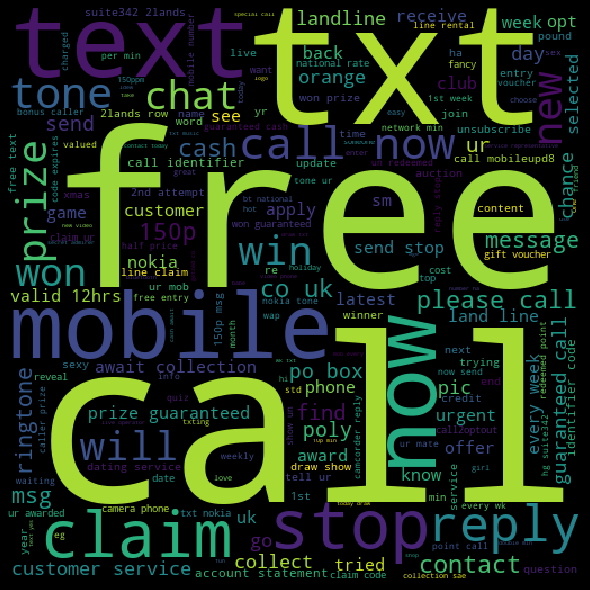

In [32]:
# C.6 generate word clouds for both spam and ham emails (NLTK lib)
spam_words = ''.join(list(df[df['spam']==1]['text_lemmatized']))
spam_wordcloud = WordCloud(width = 512,height = 512).generate(spam_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(spam_wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()



In [ ]:
# C.7 remove stop words & convert to numerical feature vectors


In [ ]:
# C.8 create data 


In [ ]:
# C.9 shuffle rows of data 


In [ ]:
# C.10 partition data (80% train - 20% test)


In [ ]:
# part D: Model Evaluation
# D.11 model selection via hyper-parameter tuning


In [ ]:
# D.12 generate ROC and AUC (bonus)


In [ ]:
# D.13 evaluate model on test day (Precision, Recall, F1 score, Confusion matrix, Accuracy)


In [ ]:
# D.14 multivariate bernoulli naive bayes model (bonus)


In [ ]:
#################      LOGISTIC REGRESSION: MULTI-CLASS CLASSIFICATION      #################
# part A: model code
# A.15 design softmax  regression classifier


In [ ]:
# A.16 compute softmax score 


In [ ]:
# A.17 implement function to compute the cross-entropy loss


In [ ]:
# A.18 implement a softmax_regression model class


In [ ]:
# B.19 read iris data (use sklearn.datasets.load_iris)


In [ ]:
# B.20 summerize variables in terms of mean, standard deviation, and quartiles (use technique from 2nd recitation)


In [ ]:
# B.21 shuffle rows of data


In [ ]:
# B.22 generate plots (seaborn)


In [ ]:
# B.23 scale the features


In [ ]:
# B.24 partion data


In [ ]:
# part C: Model Evaluation
# C.25 model selection via hyper-parameter tuning


In [ ]:
# C.26 evaluate model on test data & report accuracy & confusion matrix


In [ ]:
# C.27 implement early stop in "fit" method for softmax regression model (bonus)


In [ ]:
# C.28 implement stochastic gradient descent logistic regression algorithm (bonus)